### TabularExplainer for house-price prediction (regression)

The class `TabularExplainer` is designed for tabular data, acting as a factory of the supported tabular explainers such as LIME, SHAP and MACE. `TabularExplainer` provides a unified easy-to-use interface for all the supported explainers. In practice, we recommend applying `TabularExplainer` to generate explanations instead of using a specific explainer in the package `omnixai.explainers.tabular`.

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.ensemble
from sklearn.datasets import fetch_california_housing

from omnixai.data.tabular import Tabular
from omnixai.preprocessing.base import Identity
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import TabularExplainer
from omnixai.visualization.dashboard import Dashboard

The dataset used in this example is for the house-price prediction (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html). We recommend using `Tabular` to represent a tabular dataset that can be constructed from a pandas dataframe or a numpy array. To create a `Tabular` instance given a pandas dataframe, one needs to specify the dataframe, the categorical feature names (if exists) and the target/label column name (if exists). The package `omnixai.preprocessing` provides several useful preprocessing functions for a `Tabular` data. 

In [3]:
housing = fetch_california_housing()
df = pd.DataFrame(
    np.concatenate([housing.data, housing.target.reshape((-1, 1))], axis=1),
    columns=list(housing.feature_names) + ['target']
)
tabular_data = Tabular(df, target_column='target')
print(tabular_data)

       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  target  
0        -12

`TabularTransform` is a special transform designed for tabular data. By default, it converts categorical features into one-hot encoding, and keeps continuous-valued features (if one wants to normalize continuous-valued features, set the parameter `cont_transform` in `TabularTransform` to `Standard` or `MinMax`). The `transform` method of `TabularTransform` will transform a `Tabular` instance into a numpy array. If the `Tabular` instance has a target/label column, the last column of the transformed numpy array will be the target/label. 

If some other transformations that are not supported in the library are necessary, one can simply convert the `Tabular` instance into a pandas dataframe by calling `Tabular.to_pd()` and try different transformations with it.

After data preprocessing, we can train a random forest regressor for this task. 

In [4]:
transformer = TabularTransform(
    target_transform=Identity()
).fit(tabular_data)
x = transformer.transform(tabular_data)

x_train, x_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.80)
print('Training data shape: {}'.format(x_train.shape))
print('Test data shape:     {}'.format(x_test.shape))

rf = sklearn.ensemble.RandomForestRegressor(n_estimators=200)
rf.fit(x_train, y_train)
print('MSError when predicting the mean', np.mean((y_train.mean() - y_test) ** 2))
print('Random Forest MSError', np.mean((rf.predict(x_test) - y_test) ** 2))

Training data shape: (16512, 8)
Test data shape:     (4128, 8)
MSError when predicting the mean 1.2705150619260523
Random Forest MSError 0.23957103517549289


To initialize `TabularExplainer`, we need to set the following parameters:

  - `explainers`: The names of the explainers to apply, e.g., ["lime", "shap", "sensitivity", "pdp"].
  - `data`: The data used to initialize explainers. ``data`` is the training dataset for training the machine learning model. If the training dataset is too large, ``data`` can be a subset of it by applying `omnixai.sampler.tabular.Sampler.subsample`.
  - `model`: The ML model to explain, e.g., a scikit-learn model, a tensorflow model, a pytorch model or a black-box prediction function.
  - `preprocess`: The preprocessing function converting the raw data (a `Tabular` instance) into the inputs of `model`.
  - `postprocess` (optional): The postprocessing function transforming the outputs of ``model`` to a user-specific form, e.g., the predicted probability for each class.
  - `mode`: The task type, e.g., "classification" or "regression".
  
The preprocessing function takes a `Tabular` instance as its input and outputs the processed features that the ML model consumes. In this example, we simply call `transformer.transform`. If one uses some special transforms on pandas dataframes, the preprocess function has this kind of format: `lambda z: some_transform(z.to_pd())`.

In [5]:
preprocess = lambda z: transformer.transform(z)

We are now ready to create a `TabularExplainer`. `params` in `TabularExplainer` allows us to set parameters for each explainer applied here. For example, "kernel_width" for LIME is set to 3. 

In this example, LIME and SHAP generate local explanations while PDP (partial dependence plot) and sensitivity analysis generate global explanations. `explainers.explain` returns the local explanations, and `explainers.explain_global` returns the global explanations. `TabularExplainer` hides all the details behind the explainers, so we can simply call these two methods to generate explanations.

In [6]:
# Initialize a TabularExplainer
explainers = TabularExplainer(
    explainers=["lime", "shap", "sensitivity", "pdp"],
    mode="regression",
    data=tabular_data,
    model=rf,
    preprocess=preprocess,
    params={
        "lime": {"kernel_width": 3},
        "shap": {"nsamples": 100}
    }
)
# Apply an inverse transform, i.e., converting the numpy array back to `Tabular`
test_instances = transformer.invert(x_test[0:5])
# Generate explanations
local_explanations = explainers.explain(X=test_instances)
global_explanations = explainers.explain_global(
    params={"pdp": {"features": ["MedInc", "HouseAge", "AveRooms",
                                 "AveBedrms", "Population", "AveOccup",
                                 "Latitude", "Longitude"]}}
)

  0%|          | 0/5 [00:00<?, ?it/s]

`ipython_plot` plots the generated explanations in IPython. Parameter `index` indicates which instance to plot, e.g., `index = 0` means plotting the first instance in `test_instances`.

LIME results:


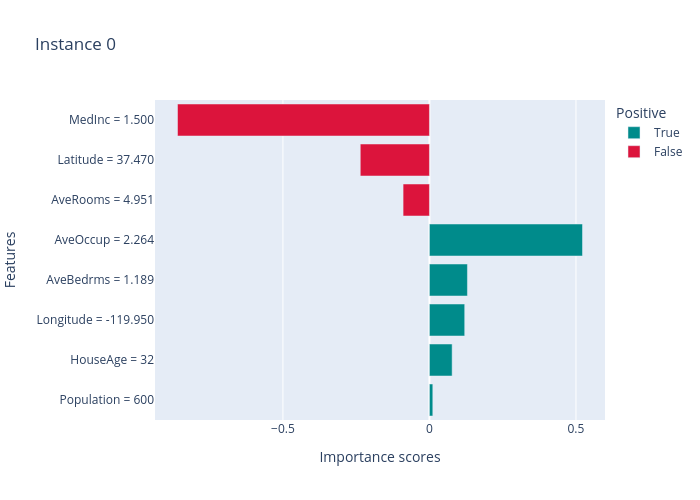

SHAP results:


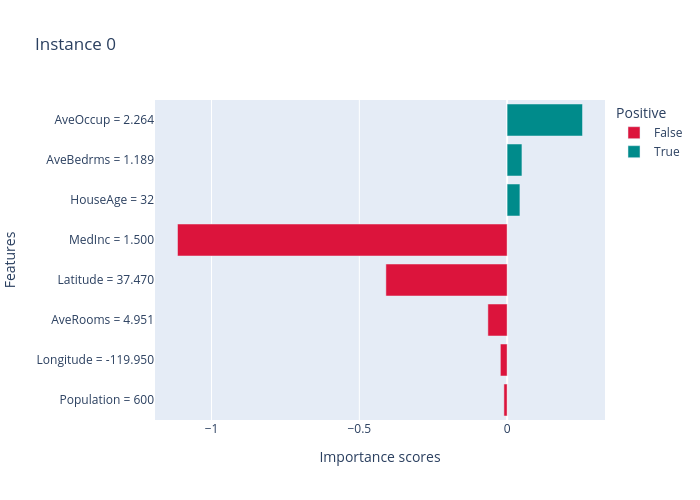

Sensitivity results:


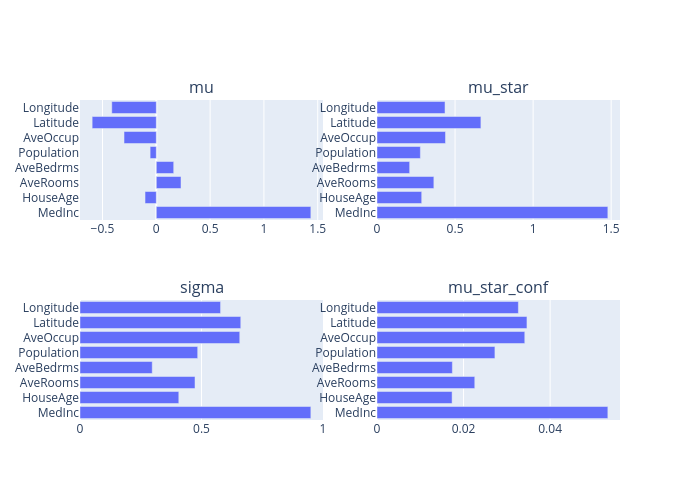

PDP results:


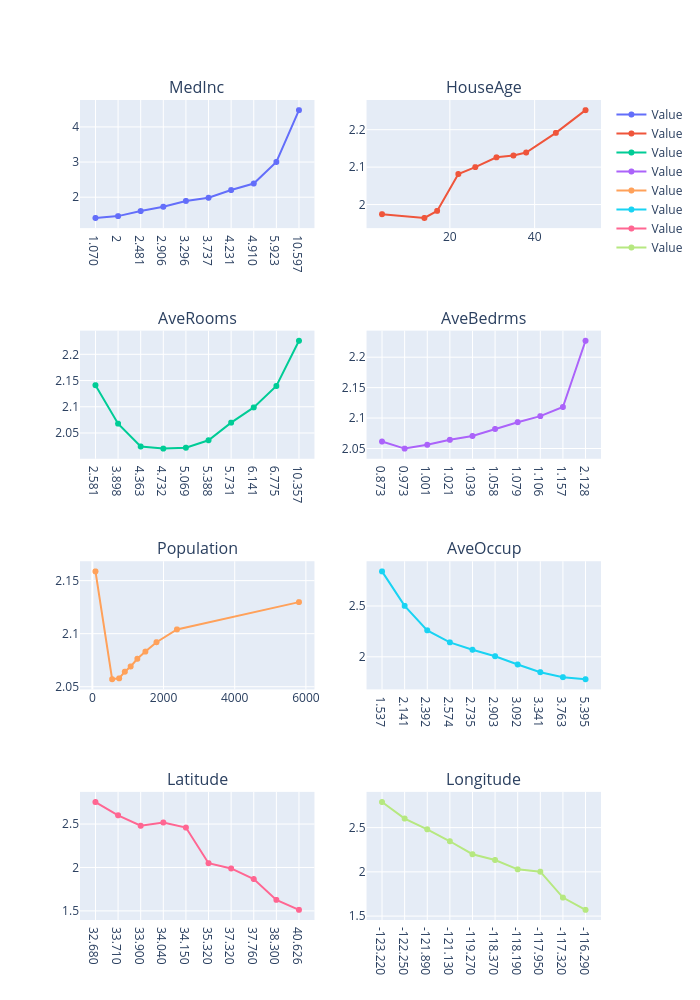

In [7]:
index=0
print("LIME results:")
local_explanations["lime"].ipython_plot(index)
print("SHAP results:")
local_explanations["shap"].ipython_plot(index)
print("Sensitivity results:")
global_explanations["sensitivity"].ipython_plot()
print("PDP results:")
global_explanations["pdp"].ipython_plot()

Given the generated explanations, we can launch a dashboard (a Dash app) for visualization by setting the test instance, the generated local explanations, the generated global explanations, the class names, and additional parameters for visualization (optional).

In [8]:
# Launch a dashboard for visualization
dashboard = Dashboard(
    instances=test_instances,
    local_explanations=local_explanations,
    global_explanations=global_explanations
)
dashboard.show()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "omnixai.visualization.dashboard" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
